### Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as gg
from pathlib import Path
import umap.umap_ as umap
from scipy import stats
from functools import reduce


## Defininng paths

In [2]:
top_dir = os.path.dirname(os.getcwd())
outpath = os.path.join(top_dir, "Figures")
dirname = "Features_map"
outdirpath = os.path.join(outpath, dirname)

def makedirectory(outdirpath):
    if not os.path.exists(outdirpath):
        try:
            os.makedirs(outdirpath)
            print("Directory is created")
        except OSError as e:
            print("Directory already existed")
        
makedirectory(outdirpath)

## Loading data and wrangling

In [3]:
path = Path("../collated/")

fname = "C-7210-01-CMP-008-gray_collapsed_sampled.csv"


fpath = os.path.join(path, fname)


df = pd.read_csv(fpath)


metadata = [col for col in df.columns if "Metadata" in col]
var = [col for col in df.columns if not "Metadata" in col]
exclude_var = ['Cells_Correlation_Costes_DNA_Mito',
 'Cytoplasm_Correlation_Costes_DNA_Mito',
 'Cytoplasm_Correlation_Costes_DNA_RNA']

variables = [v for v in var if v not in exclude_var]


df['Metadata_Target'].replace(np.nan, 'NA', inplace=True)
df['Metadata_Annotation'].replace('active ', 'active', inplace=True)

cellline = "A549"

drug_samples = ['DMSO', 'BSJ-04-030', 'BSJ-03-136'] # for Secret pathway


## Assigning Features groups, channels and calculating mean z-scores

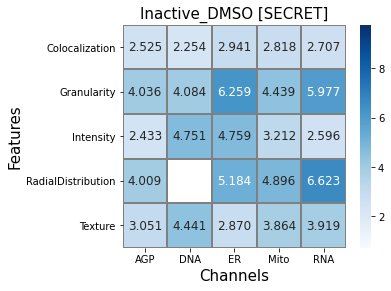

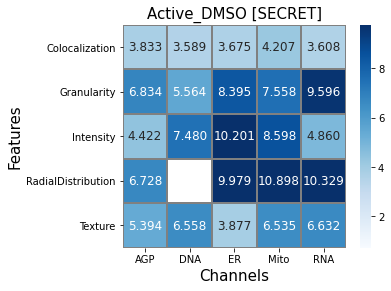

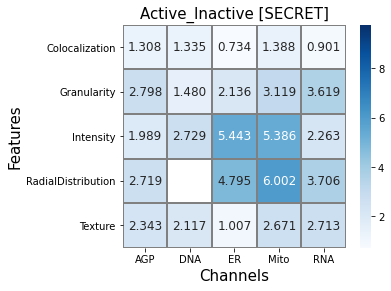

In [7]:

def feature_grid(df, cellline, drug_samples,comparison):
    
    
     ## Selecting dataframe for specific cellline and samples
        
    d = df.query('Metadata_cell_line in @ cellline and Metadata_compound_name in @ drug_samples')


    feat = [col for col in d.columns if not "Metadata" in col]

    featlist =  ['Metadata_compound_name'] + feat



    dn = (d.loc[:, featlist].groupby('Metadata_compound_name')
      .mean()
      .T
      .reset_index()
      .rename(columns={'index': "variables"})
     )


    dn['Compartment'] = np.where(dn.variables.str.contains("Cells"), 'Cells',
                np.where(dn.variables.str.contains("Nuclei"), 'Nuclei', 
                np.where(dn.variables.str.contains("Cytoplasm"), 'Cytoplasm', 'NA')))


    dn['Features'] = np.where(dn.variables.str.contains("RadialDistribution"), 'RadialDistribution', 
                np.where(dn.variables.str.contains("Texture"), 'Texture', 
                np.where(dn.variables.str.contains("Intensity"), 'Intensity',
                np.where(dn.variables.str.contains("AreaShape"), 'AreaShape',
                np.where(dn.variables.str.contains("Correlation"), 'Correlation',
                np.where(dn.variables.str.contains("Neighbors"), 'Neighbors',
                np.where(dn.variables.str.contains("Granularity"), 'Granularity', 'NA')))))))
    
    # Taking mean absolute  z scores

    dn = dn.assign(Active_DMSO = lambda x: abs(x['BSJ-03-136']) - abs(x['DMSO']),
                  Inactive_DMSO = lambda x: abs(x['BSJ-04-030']) - abs(x['DMSO']),
                  Active_Inactive = lambda x: abs(x['BSJ-03-136']) - abs(x['BSJ-04-030']))
    
    
    channels = ['DNA', 'AGP', 'Mito', 'ER', 'RNA']

    feat_groups = ['RadialDistribution', 'Texture', 'Intensity', 'Correlation', 'Granularity']
    
    area_neigh = ['AreaShape','Neighbors']
    
      

    data = []

    for gp in feat_groups:
   
        tmp = dn.query("Features in @ gp")


        for ch in channels:
        
         
            if isinstance(comparison, str):
                
                comparison = [comparison]
                
            
            for comp in comparison:
            
            
                tmp1 = (tmp[tmp.variables.str.contains(ch)]
                   .groupby(['Features'])[comp]
                   .mean()
                   )
        
                if not tmp1.empty:
              
                    Channel = str(ch)
                    Feature = str(gp)
                
                    tmp2 = pd.DataFrame([Feature, Channel]).T            
                    tmp2.columns = ['Features', 'Channels']
                    tmp2[comp] = tmp1[0]
                    data.append(tmp2)

    data = pd.concat(data)
    
   


    return data


## Creating dataframes for three comparison and merging them    
    
dt_1 = feature_grid(df, cellline, drug_samples, 'Inactive_DMSO') 
dt_2 = feature_grid(df, cellline, drug_samples, 'Active_DMSO')
dt_3 = feature_grid(df, cellline, drug_samples, 'Active_Inactive')


## Renaming "Correlation" to "Colocalization"

prf = (reduce(lambda x,y: pd.merge(x,y, on=['Features', 'Channels'], how='left'), [dt_1, dt_2, dt_3])
       .replace('Correlation', 'Colocalization', regex=True)
       
      )



### calculating the min and 95th percentile value for the color scale bar in plotting for comparison

min_value = prf[['Active_DMSO','Inactive_DMSO', 'Active_Inactive']].min().min()

max_value = np.quantile(prf[['Active_DMSO','Inactive_DMSO', 'Active_Inactive']], .95)


comparison = ['Inactive_DMSO', 'Active_DMSO', 'Active_Inactive']

for cmp in comparison:

    dt = prf.pivot('Features', 'Channels')[cmp]
       
    plt.figure(figsize=(5,5))
    
    plt.xlabel('Channels', size=15)
    plt.ylabel('Features', size=15)
    plt.title(str(cmp) + ' [SECRET]', size=15)
    ax = sns.heatmap(dt, annot=True, fmt=".3f",annot_kws={"size": 12}, linewidths=1, vmin=min_value, vmax=max_value, linecolor="gray", square=True, cbar_kws={"shrink": .82}, cmap="Blues", cbar=True)
    
    fig = ax.get_figure()

    fig.savefig(outdirpath + '/' + str(cmp) + '_allcompartments_blues.png', bbox_inches="tight")
    


## Neighobors feature

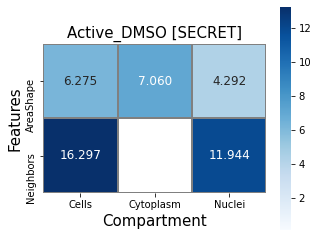

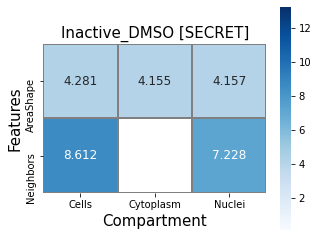

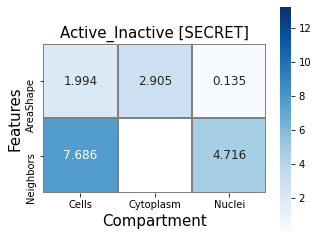

In [8]:

d = df.query('Metadata_cell_line in @ cellline and Metadata_compound_name in @ drug_samples')


feat = [col for col in d.columns if not "Metadata" in col]

featlist =  ['Metadata_compound_name'] + feat



dn = (d.loc[:, featlist].groupby('Metadata_compound_name')
    .mean()
    .T
    .reset_index()
    .rename(columns={'index': "variables"})
    )


dn['Compartment'] = np.where(dn.variables.str.contains("Cells"), 'Cells',
             np.where(dn.variables.str.contains("Nuclei"), 'Nuclei', 
            np.where(dn.variables.str.contains("Cytoplasm"), 'Cytoplasm', 'NA')))

dn['Features'] = np.where(dn.variables.str.contains("AreaShape"), 'AreaShape',
                np.where(dn.variables.str.contains("Neighbors"), 'Neighbors', 'NA'))


dn = dn.query("Features != 'NA'")
    
#Taking mean absolute  z scores

dn = dn.assign(Active_DMSO = lambda x: abs(x['BSJ-03-136']) - abs(x['DMSO']),
                  Inactive_DMSO = lambda x: abs(x['BSJ-04-030']) - abs(x['DMSO']),
                  Active_Inactive = lambda x: abs(x['BSJ-03-136']) - abs(x['BSJ-04-030']))

  

selected_column = ["Active_DMSO","Inactive_DMSO", "Active_Inactive"]

data = []
for sc in selected_column:
    
    tmp2 = (dn.groupby(['Features', 'Compartment'])[sc]
    .mean()
    .reset_index()
           )
    
    data.append(tmp2)
            
            
            
prf = pd.concat(data, axis=1)
      


prf = prf.loc[:, ~prf.columns.duplicated()] 
                      

### calculating the min and 95th percentile value for the color scale bar in plotting for comparison

min_value = prf[['Active_DMSO','Inactive_DMSO', 'Active_Inactive']].min().min()

max_value = np.quantile(prf[['Active_DMSO','Inactive_DMSO', 'Active_Inactive']], .95)


for sec in selected_column:
    
    tmp3 = prf.pivot('Features', 'Compartment')[sec]

    ### Plotting
      
    plt.figure(figsize=(5,5))
    plt.xlabel('Compartment', size=15)
    plt.ylabel('Features', size=15)
    plt.title(str(sec) + ' [SECRET]', size=15)
    ax = sns.heatmap(tmp3, annot=True, fmt=".3f",annot_kws={"size": 12}, vmin = min_value, vmax = max_value,linewidths=1, linecolor="gray", square=True, cbar_kws={"shrink": .82}, cmap="Blues", cbar=True)
    
    fig = ax.get_figure()

    fig.savefig(str(outdirpath) + '/' + str(sec) + '_areashape_neighbors_Blues.png', bbox_inches="tight")
     

